# AC Optics

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from analysis import *
import glob
import re
import hvplot.xarray
font = {'family':'serif',
        'weight': 'normal',
        'size': 32}
plt.rc('font',**font)
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#000000','#e3130f','#0962f6',
                                                    '#20c168','#fc76f3','#2efef4'])
plt.rc('text',usetex=True)

## Constants

In [2]:
mu0 = np.pi*4*1e-7
Ms = 0.93/mu0 # T
hbar = 1.055e-34
e = 1.6e-19
V = 1. #Vrms
R = 336.123 #ohms
w = 20e-4 #cm
t = 4e-7 #cm
A = w*t
I = V/R
J = I/A
tco = 1.15e-9
rho_co = 9.59e-8 #ohm m
rho_pt = 40e-8 #33.33e-8 #ohm m
R4pt = 1/(1/(rho_pt*80e-6/20e-6/4e-9) + 1/(rho_co*80e-6/20e-6/tco))
Isplit = rho_co*80e-6/20e-6/tco/(rho_pt*80e-6/20e-6/4e-9 + rho_co*80e-6/20e-6/tco)
t2xi = 2*e*Ms*tco/hbar/1e4

In [3]:
Rahe = 0.3548465783757197
Rphe = 0.2006307288681012

## Tilting

In [4]:
def load_file(f):
    return pd.read_csv(f,comment='#').set_index('sweep_field').drop(columns='elapsed_time').to_xarray()
def load(ang):
    ms = [-1,1]
    m_dict = {}
    for m in ms:
        if m == 1:
            f = glob.glob('./*M+*V5.0000V*A%.1f*.csv'%ang)[0]
            a = load_file(f)
        if m == -1:
            f = glob.glob('./*M-*V5.0000V*A%.1f*.csv'%ang)[0]
            a = load_file(f)
        m_dict[m] = a
    return combine_new_dim(m_dict,'M')

In [5]:
angs = np.arange(-45,135,45)
a = combine_new_dim({ang: load(ang) for ang in angs},'field_azimuth')


In [6]:
def lin(x,m,b):
    return m*x+b
def lin_guess(*args,**kwargs):
    return [1,1]
def quad(x,a,b,c):
    return a*x**2 + b*x + c
def quad_guess(*args,**kwargs):
    return [1,1,1]

xport_w1_fit = fit_dataArray(a.TX1,quad,quad_guess,['a','b','c'],'sweep_field')
xport_w2_fit = fit_dataArray(a.TY2,lin,lin_guess,['a','b'],'sweep_field')

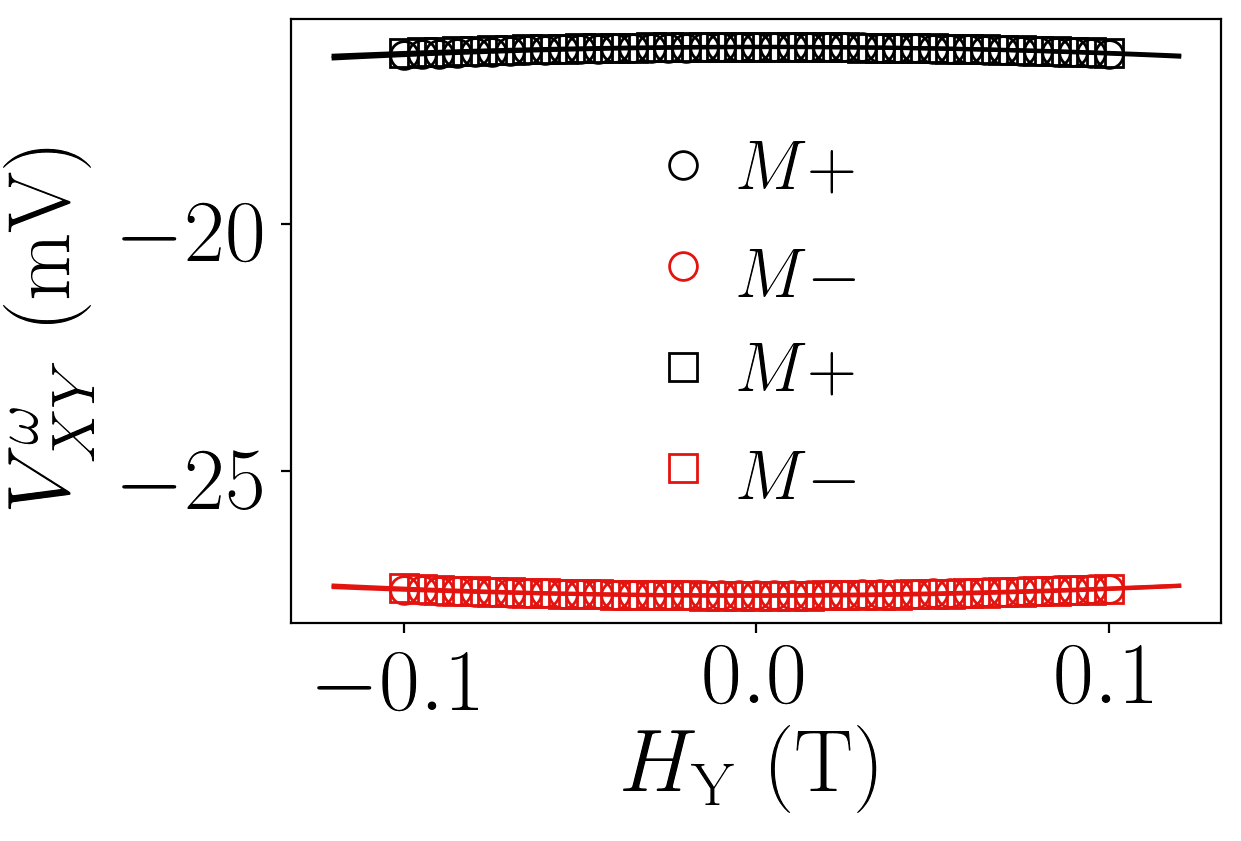

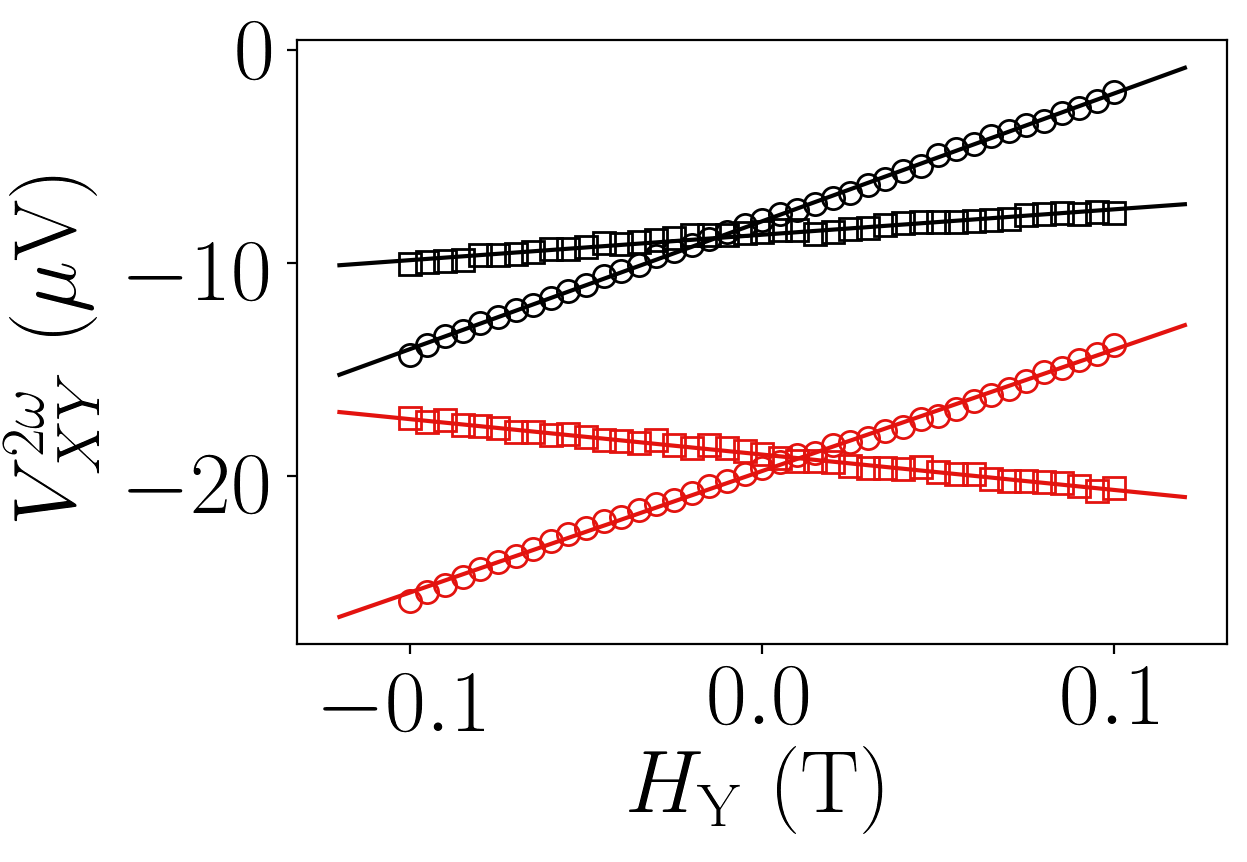

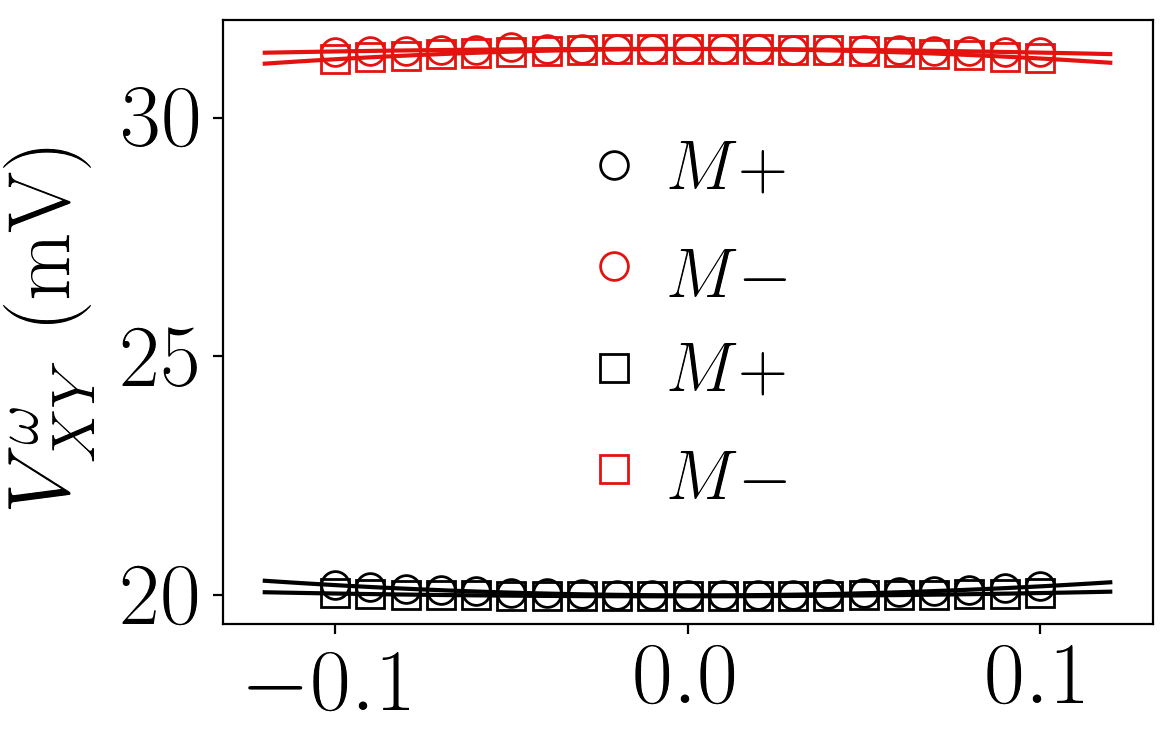

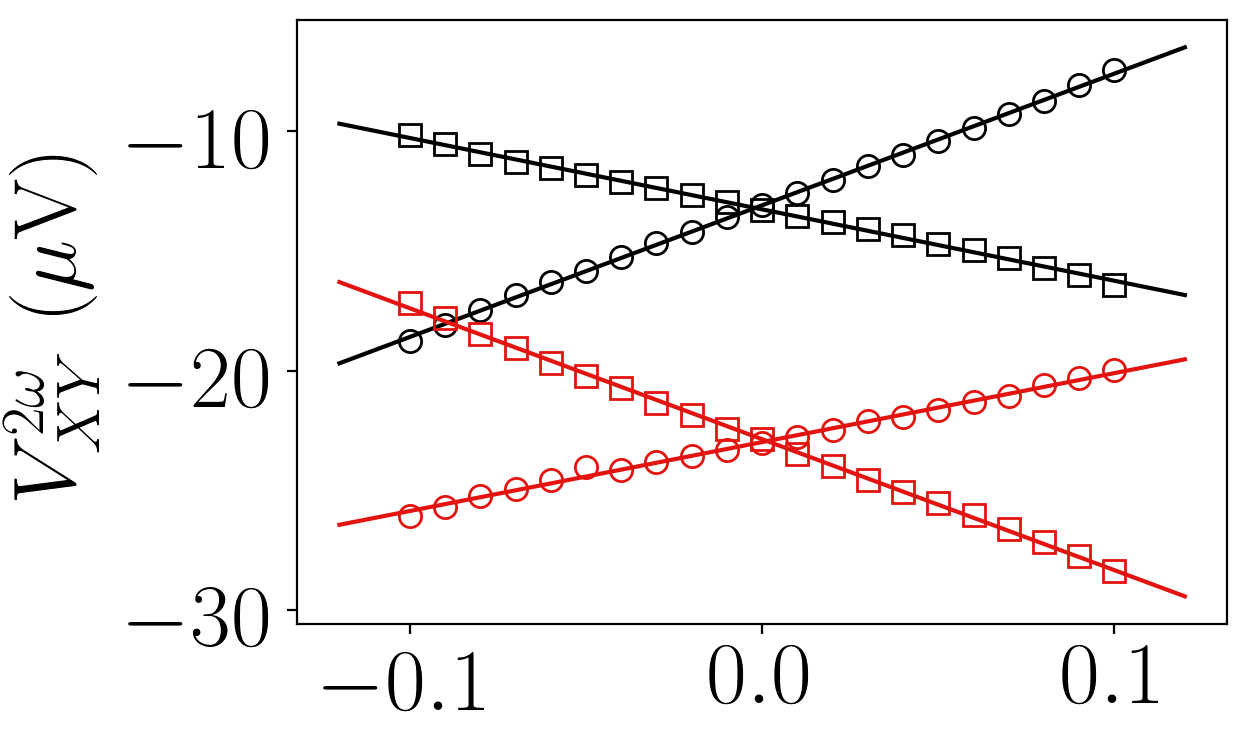

In [7]:
def plot_parab(tech,m,ang,newfig=False,fit=False,**kwargs):
    if tech == 'optics':
        comp = 'ThetaK'
        fit_ds = op_w1_fit.sel(M=m,field_azimuth=ang)
        fac=-1
    if tech == 'xport':
        comp = 'TX1'
        fit_ds = xport_w1_fit.sel(M=m,field_azimuth=ang)
        fac =1
    if m == 1:
        label = '$M+$'
        color = 'C0'
    else:
        label = '$M-$'
        color = 'C1'
    if newfig:
        plt.figure(dpi=200)
    plt.errorbar(a.sweep_field,fac*a.sel(M=m,field_azimuth=ang)[comp]*1e3,
                 ms=10,fillstyle='none',label=label,color = color,**kwargs)
    if tech == 'optics':
        plt.ylabel('$\\theta_k$ (mRad)')
    if tech == 'xport':
        plt.ylabel('$V^{\omega}_{XY}$ (mV)')
    if ang == 90:
        plt.xlabel('$H_{\\rm{X}}$ (T)')
    if ang == 0:
        plt.xlabel('$H_{\\rm{Y}}$ (T)')
    
    if fit:
        xx = np.linspace(-0.12,0.12,100)
        plt.errorbar(xx,fac*1e3*quad(xx,
                         fit_ds.a.values,
                         fit_ds.b.values,
                         fit_ds.c.values),color = color)
    
def plot_lin(tech,m,ang,newfig=False,fit=False,off=0,**kwargs):
    if tech == 'optics':
        comp = 'DeltaThetaK'
        fac = -1
        fit_ds = op_w2_fit.sel(M=m,field_azimuth=ang)
        if ang == 90:
            fac *= -1
    if tech == 'xport':
        comp = 'TY2'
        fac = 1
        fit_ds = xport_w2_fit.sel(M=m,field_azimuth=ang)
    if m == 1:
        label = '$M+$'
        color = 'C0'
    else:
        label = '$M-$'
        color = 'C1'
    if newfig:
        plt.figure(dpi=200)
    plt.errorbar(a.sweep_field,fac*a.sel(M=m,field_azimuth=ang)[comp]*1e6 + off,
                 ms=8,fillstyle='none',label=label,color = color,**kwargs)
    plt.ylabel('$\\Delta\\theta_k$ ($\\mu$Rad)')
    if ang == 90:
        plt.xlabel('$H_{\\rm{X}}$ (T)')
    if ang == 0:
        plt.xlabel('$H_{\\rm{Y}}$ (T)')
    if tech == 'optics':
        plt.ylabel('$\\Delta\\theta_k$ ($\\mu$Rad)')
    if tech == 'xport':
        plt.ylabel('$V^{2\omega}_{XY}$ ($\\mu$V)')
    if fit:
        xx = np.linspace(-0.12,0.12,100)
        plt.errorbar(xx,fac*1e6*lin(xx,
                         fit_ds.a.values,
                         fit_ds.b.values)+off,color = color)
    

plot_parab('xport',1,90,newfig=True,fit=True,fmt='o')
plot_parab('xport',-1,90,fit=True,fmt='o')   
plot_parab('xport',1,0,fit=True,fmt='s')
plot_parab('xport',-1,0,fit=True,fmt='s')   
plt.legend(loc='center',bbox_to_anchor=(0.5,0.5),
           frameon=False, columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=25)
plot_lin('xport',1,90,newfig=True,fit=True,off=0,fmt='o')
plot_lin('xport',-1,90,fit=True,off=0,fmt='o')
plot_lin('xport',1,0,fit=True,off=0,fmt='s')
plot_lin('xport',-1,0,fit=True,off=0,fmt='s')

plot_parab('xport',1,45,newfig=True,fit=True,fmt='o')
plot_parab('xport',-1,45,fit=True,fmt='o')   
plot_parab('xport',1,-45,fit=True,fmt='s')
plot_parab('xport',-1,-45,fit=True,fmt='s')   
plt.legend(loc='center',bbox_to_anchor=(0.5,0.5),
           frameon=False, columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=25)
plot_lin('xport',1,45,newfig=True,fit=True,off=0,fmt='o')
plot_lin('xport',-1,45,fit=True,off=0,fmt='o')
plot_lin('xport',1,-45,fit=True,off=0,fmt='s')
plot_lin('xport',-1,-45,fit=True,off=0,fmt='s')

# plt.legend(loc='center',bbox_to_anchor=(0.5,0.5),
#            frameon=False, columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=25)

# plot_parab(1,90,newfig=True,color='C0',fmt='o')
# plot_parab(-1,90,color='C1',fmt='o')


In [8]:
xport_Meff = float(1/np.sqrt(abs(xport_w1_fit.a.sel(field_azimuth=[0,90])*2/Rahe/(5/R))).mean())

print(xport_Meff)

0.44370590604729143


In [9]:
xi = Rphe/Rahe
xport_SOT = -xport_w2_fit.a/xport_w1_fit.a # no factor of 2 therefore no multiply by 2 at the end
xport_SOT.name = 'H'
xport_SOT_err = xport_w2_fit.a/xport_w1_fit.a*np.sqrt((xport_w2_fit.a_err/xport_w2_fit.a)**2 +\
                                                      (xport_w1_fit.a_err/xport_w1_fit.a)**2)
xport_SOT_err.name = 'H_err'
xport_SOT = xr.merge([xport_SOT,xport_SOT_err])
xport_SOT = xport_SOT.assign(H_norm = lambda x: x.H*A*1e4/(3/R * Isplit))
xport_SOT = xport_SOT.assign(H_norm_err = lambda x: x.H_err*A*1e4/(3/R * Isplit))

xport_SOT_PHC = xport_w2_fit.a/xport_w1_fit.a/2
xport_SOT_PHC.name = 'H'
xport_SOT_PHC_err = xport_w2_fit.a/xport_w1_fit.a/2*np.sqrt((xport_w2_fit.a_err/xport_w2_fit.a)**2 +\
                                                      (xport_w1_fit.a_err/xport_w1_fit.a)**2)
xport_SOT_PHC_err.name = 'H_err'
xport_SOT_PHC = xr.merge([xport_SOT_PHC,xport_SOT_PHC_err])
xport_SOT_PHC = combine_new_dim({
    90: -2*(xport_SOT_PHC.H.sel(field_azimuth=90) + xi*xport_SOT_PHC.M*xport_SOT_PHC.H.sel(field_azimuth=0))\
           /(1-xi**2),
    0: -2*(xport_SOT_PHC.H.sel(field_azimuth=0) + xi*xport_SOT_PHC.M*xport_SOT_PHC.H.sel(field_azimuth=90))\
           /(1-xi**2)}, 'field_azimuth')
xport_SOT_PHC.name = 'H'
xport_SOT_PHC_err = 2*xport_SOT_PHC_err/(1-xi**2)
xport_SOT_PHC_err.name = 'H_err'
xport_SOT_PHC = xr.merge([xport_SOT_PHC,xport_SOT_PHC_err])

xport_SOT_PHC = xport_SOT_PHC.assign(H_norm = lambda x: x.H*A*1e4/(3/R * Isplit))
xport_SOT_PHC = xport_SOT_PHC.assign(H_norm_err = lambda x: x.H_err*A*1e4/(3/R * Isplit))

xport_SOT = combine_new_dim({'noPHC':xport_SOT,'PHC':xport_SOT_PHC},'PHC')

xport_SOT

<xarray.Dataset>
Dimensions:        (M: 2, PHC: 2, field_azimuth: 4)
Coordinates:
  * M              (M) int64 -1 1
  * field_azimuth  (field_azimuth) int64 -45 0 45 90
  * PHC            (PHC) <U5 'noPHC' 'PHC'
Data variables:
    H              (PHC, field_azimuth, M) float64 -0.002647 ... 0.006856
    H_err          (PHC, field_azimuth, M) float64 1.748e-05 ... -6.027e-05
    H_norm         (PHC, field_azimuth, M) float64 -5.217e-06 ... 1.351e-05
    H_norm_err     (PHC, field_azimuth, M) float64 3.447e-08 ... -1.188e-07

In [10]:
xport_SOT.H.sel(M=-1,PHC='noPHC')*1e3

<xarray.DataArray 'H' (field_azimuth: 4)>
array([-2.6467632 ,  1.17976372,  4.4228223 , -4.54249407])
Coordinates:
    M              int64 -1
  * field_azimuth  (field_azimuth) int64 -45 0 45 90
    PHC            <U5 'noPHC'

In [11]:
(-2.6467632/2 - 4.4228223/2)*np.sqrt(2)*-1

4.99895184722809

In [12]:
(-2.6467632/2 + 4.4228223/2)*np.sqrt(2)*-1

-1.2558634333980765

In [13]:
xport_SOT.H_err.sel(M=-1,PHC='noPHC')*1e3

<xarray.DataArray 'H_err' (field_azimuth: 4)>
array([ 0.01748495, -0.01726056, -0.51758653,  0.04082298])
Coordinates:
    M              int64 -1
  * field_azimuth  (field_azimuth) int64 -45 0 45 90
    PHC            <U5 'noPHC'

In [14]:
hy45/1e4*1e3

NameError: name 'hy45' is not defined

In [ ]:
hy45_err/1e4*1e3

##### Using NIST analysis

In [ ]:
Cahe = -(3/R)*Rahe/2/xport_Meff**2
Cphe = -(3/R)*Rphe/2/xport_Meff**2
Spx = xport_w2_fit.sel(M=1,field_azimuth=90).a
Spx_err = xport_w2_fit.sel(M=1,field_azimuth=90).a_err
Spy = xport_w2_fit.sel(M=1,field_azimuth=0).a
Spy_err = xport_w2_fit.sel(M=1,field_azimuth=0).a_err
Smx = xport_w2_fit.sel(M=-1,field_azimuth=90).a
Smx_err = xport_w2_fit.sel(M=-1,field_azimuth=90).a_err
Smy = xport_w2_fit.sel(M=-1,field_azimuth=0).a
Smy_err = xport_w2_fit.sel(M=-1,field_azimuth=0).a_err

C = 1/(2*Cahe**2 - 2*Cphe**2)

hx = 1e4*C*(-Cahe*Spx - Cahe*Smx - Cphe*Spy + Cphe*Smy)
hx_err = 1e4*C*(np.sqrt((Cahe*Spx_err)**2 + (Cahe*Smx_err)**2 + (Cphe*Spy_err)**2 + (Cphe*Smy_err)**2))
hy = 1e4*C*(-Cphe*Spx - Cphe*Smx - Cahe*Spy + Cahe*Smy)
hy_err = 1e4*C*(np.sqrt((Cphe*Spx_err)**2 + (Cphe*Smx_err)**2 + (Cahe*Spy_err)**2 + (Cahe*Smy_err)**2))


# Sp45 = xport_w2_fit.sel(M=1,field_azimuth=45).a
# Sm45 = xport_w2_fit.sel(M=-1,field_azimuth=45).a
# Sp135 = xport_w2_fit.sel(M=1,field_azimuth=-45).a
# Sm135 = -xport_w2_fit.sel(M=-1,field_azimuth=-45).a
# Sp45_err = xport_w2_fit.sel(M=1,field_azimuth=45).a_err
# Sm45_err = xport_w2_fit.sel(M=-1,field_azimuth=45).a_err
# Sp135_err = xport_w2_fit.sel(M=1,field_azimuth=-45).a_err
# Sm135_err = xport_w2_fit.sel(M=-1,field_azimuth=-45).a_err

# C45 = 1/np.sqrt(2)/2/Cahe

# hx45 = 1e4*C45*(-Sp45 - Sm45 - Sp135 - Sm135)
# hx45_err = 1e4*C45*(np.sqrt((Sp45_err)**2 + (Sm45_err)**2 + (Sp135_err)**2 + (Sm135_err)**2))
# hy45 = 1e4*C45*(-Sp45 + Sm45 - Sp135 + Sm135)
# hy45_err = 1e4*C45*(np.sqrt((Sp45_err)**2 + (Sm45_err)**2 + (Sp135_err)**2 + (Sm135_err)**2))

Sp45 = xport_w2_fit.sel(M=1,field_azimuth=45).a/xport_w1_fit.sel(M=1,field_azimuth=45).a/2
Sm45 = xport_w2_fit.sel(M=-1,field_azimuth=45).a/xport_w1_fit.sel(M=-1,field_azimuth=45).a/2
Sp135 = xport_w2_fit.sel(M=1,field_azimuth=-45).a/xport_w1_fit.sel(M=1,field_azimuth=-45).a/2
Sm135 = xport_w2_fit.sel(M=-1,field_azimuth=-45).a/xport_w1_fit.sel(M=-1,field_azimuth=-45).a/2
Sp45_err = xport_w2_fit.sel(M=1,field_azimuth=45).a_err/xport_w1_fit.sel(M=1,field_azimuth=45).a/2
Sm45_err = xport_w2_fit.sel(M=-1,field_azimuth=45).a_err/xport_w1_fit.sel(M=-1,field_azimuth=45).a/2
Sp135_err = xport_w2_fit.sel(M=1,field_azimuth=-45).a_err/xport_w1_fit.sel(M=1,field_azimuth=-45).a/2
Sm135_err = xport_w2_fit.sel(M=-1,field_azimuth=-45).a_err/xport_w1_fit.sel(M=-1,field_azimuth=-45).a/2

hx45 = -1e4*np.sqrt(2)*(Sm45 - Sm135)
hx45_err = 1e4*np.sqrt(2)*(np.sqrt((Sm45_err)**2 + (Sm135_err)**2))
hy45 = 1e4*np.sqrt(2)*(Sm45 + Sm135)
hy45_err = 1e4*np.sqrt(2)*(np.sqrt((Sm45_err)**2 + (Sm135_err)**2))

hx_full = 1e4*((-2*Cahe**3 + Cahe*Cphe**2)/(2*(4*Cahe**4 + Cphe**4))*Spx +\
     (-2*Cahe**3 + Cahe*Cphe**2)/(2*(4*Cahe**4 + Cphe**4))*Smx +\
     (Cphe**3)/(8*Cahe**4 + 2*Cphe**4)*Spy -\
     (Cphe**3)/(8*Cahe**4 + 2*Cphe**4)*Spy -\
     (Cahe)/np.sqrt(2)/(4*Cahe**2 - 4*Cahe*Cphe + 2*Cphe**2)*Sp45 -\
     (Cahe)/np.sqrt(2)/(4*Cahe**2 + 4*Cahe*Cphe + 2*Cphe**2)*Sm45 -\
     (Cahe)/np.sqrt(2)/(4*Cahe**2 + 4*Cahe*Cphe + 2*Cphe**2)*Sp135 -\
     (Cahe)/np.sqrt(2)/(4*Cahe**2 - 4*Cahe*Cphe + 2*Cphe**2)*Sm135)

hx_full_err = 1e4*np.sqrt((((-2*Cahe**3 + Cahe*Cphe**2)/(2*(4*Cahe**4 + Cphe**4))*Spx_err)**2 +\
     ((-2*Cahe**3 + Cahe*Cphe**2)/(2*(4*Cahe**4 + Cphe**4))*Smx_err)**2 +\
     ((Cphe**3)/(8*Cahe**4 + 2*Cphe**4)*Spy_err)**2 +\
     ((Cphe**3)/(8*Cahe**4 + 2*Cphe**4)*Spy_err)**2 +\
     ((Cahe)/np.sqrt(2)/(4*Cahe**2 - 4*Cahe*Cphe + 2*Cphe**2)*Sp45_err)**2 +\
     ((Cahe)/np.sqrt(2)/(4*Cahe**2 + 4*Cahe*Cphe + 2*Cphe**2)*Sm45_err)**2 +\
     ((Cahe)/np.sqrt(2)/(4*Cahe**2 + 4*Cahe*Cphe + 2*Cphe**2)*Sp135_err)**2 +\
     ((Cahe)/np.sqrt(2)/(4*Cahe**2 - 4*Cahe*Cphe + 2*Cphe**2)*Sm135_err))**2)

#====================================


plt.figure(dpi=200)

# plt.errorbar([0],-hx_full*t2xi/(3/R/20e-6/4e-9*Isplit),hx_full_err*t2xi/(3/R/20e-6/4e-9*Isplit),
#              fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C4',
#              label='Pseudo. Inv. $\{-45^\circ,0^\circ,45^\circ,90^\circ\}$')

# plt.errorbar([0],-hx*t2xi/(3/R/20e-6/4e-9*Isplit),hx_err*t2xi/(3/R/20e-6/4e-9*Isplit),
#              fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
#              label='Pseudo. Inv. $\{0^\circ,90^\circ\}$')

plt.errorbar([1],hx45*t2xi/(3/R/20e-6/4e-9*Isplit),hx_err*t2xi/(3/R/20e-6/4e-9*Isplit),
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
             label='Pseudo. Inv. $\{45^\circ,-45^\circ\}$')

plt.errorbar([2],
             abs(xport_SOT.sel(field_azimuth=90,PHC='PHC',M=-1)).H.values*1e4*t2xi/(3/R/20e-6/4e-9*Isplit),
             abs(xport_SOT.sel(field_azimuth=90,PHC='PHC',M=-1)).H_err.values*1e4*t2xi/(3/R/20e-6/4e-9*Isplit),
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C2',
             label='Hayashi; PHC')
plt.errorbar([3],
             abs(xport_SOT.sel(field_azimuth=90,PHC='noPHC',M=-1)).H.values*1e4*t2xi/(3/R/20e-6/4e-9*Isplit),
             abs(xport_SOT.sel(field_azimuth=90,PHC='noPHC',M=-1)).H_err.values*1e4*t2xi/(3/R/20e-6/4e-9*Isplit),
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C3',
             label='Hayashi; no PHC')


# plt.xlabel('$J_e$ ($\\times 10^7$ A/cm$^2$)')
plt.xticks([])
plt.ylabel('$\\xi_{\\rm{DL}}$')
plt.legend(loc='center',bbox_to_anchor=(0.5,0.5),ncol=2,frameon=False,
           columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=12)